# Description of Raw Data

This notebook is used to visualize the Raw Data from the Gesture Glove Experiments.

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# imports
from typing import Callable, List
import functools
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
from dataclasses import dataclass
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import tqdm
import random
import time
from datetime import datetime, timedelta
import gestureanalysis.read_raw as rr
import gestureanalysis.raw_preprocessing_and_cleaning as rp
import gestureanalysis.utils as utils
import gestureanalysis.specific_utils as sutils
import gestureanalysis.image_utils as iutils
import gestureanalysis.generate_channel_images as gci
import gestureanalysis.generate_historgrams as ghi
import gestureanalysis.generate_boxplots as gbo
from gestureanalysis.constants import Constants
import operator

In [28]:
base_path = "/home/jsimon/Documents/thesis/gesture-analysis/data/"
base_path_raw = base_path+"raw/all"
time_groups_path_corrected_pickl = base_path+"transformed/time_added/all/time-and-groups-corrected-all.pkl"
stats_added_path_pickl = base_path+"transformed/stats_added/all/raw_stats-added-all.pkl"

In [4]:
# check working directory and adopt if needed
import os
os.getcwd()

'/home/jsimon/Documents/thesis/gesture-analysis/scripts'

In [6]:
# in case you need to reload, and know it exists:
with open( time_groups_path_corrected_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

## Describe and visualise Data and Labels

After we have some confidence in the recovered labeling it is time to describe the data and the labels

In [25]:
# correct corrupted labels
print(users.keys())
print('num users: ', len(users.keys()))

dict_keys(['AB73', 'AE30', 'AF82', 'AL29', 'AW18', 'CB23', 'CB24', 'CF58', 'DG12', 'DH42', 'DL24', 'JL61', 'JQ28', 'JS52', 'MF20', 'MS55', 'PC29', 'PM32', 'PS42', 'RR45', 'RW32', 'SF1', 'YW13'])
num users:  23


In [81]:
if 'glove_merged' not in users['AE30']:
    users['AE30']['glove_merged'] = []
num_users = len(users)
filecounts = [data["filecount"] for usr, data in users.items()]
glove_records = [len(data["glove_merged"]) for usr, data in users.items()]
sts = zip(filecounts, glove_records)

print(f"we have {num_users} participants. ")
print(f"on avarage we have:")
print(f" glove records: {sum(glove_records)/num_users}")
print(f" avarage time: {(sum(glove_records)/num_users)*Constants.dt_t}")
print("")
for s in sts:
    print(f"files: {s[0]}, glove records: {s[1]}, time {s[1]*Constants.dt_t}")
del users['AE30']['glove_merged']

we have 23 participants. 
on avarage we have:
 glove records: 126742.39130434782
 avarage time: 0:25:20.908696

files: 3, glove records: 183008, time 0:36:36.096000
files: 10, glove records: 0, time 0:00:00
files: 11, glove records: 105835, time 0:21:10.020000
files: 3, glove records: 184276, time 0:36:51.312000
files: 3, glove records: 103159, time 0:20:37.908000
files: 3, glove records: 105331, time 0:21:03.972000
files: 6, glove records: 106082, time 0:21:12.984000
files: 43, glove records: 119296, time 0:23:51.552000
files: 3, glove records: 104551, time 0:20:54.612000
files: 3, glove records: 110435, time 0:22:05.220000
files: 3, glove records: 181278, time 0:36:15.336000
files: 34, glove records: 112566, time 0:22:30.792000
files: 3, glove records: 191596, time 0:38:19.152000
files: 3, glove records: 187429, time 0:37:29.148000
files: 3, glove records: 103021, time 0:20:36.252000
files: 28, glove records: 108852, time 0:21:46.224000
files: 3, glove records: 120138, time 0:24:01.6

### Timing of the Labels

Additionally let's show the timings of the labels again:

In [27]:
def describe_hist(username, userdata, timerange_key):
    hist, _ = sutils.four_pin_hist(userdata['lbl_groups_fl'], timerange_key)
    if hist[0] > 0:
        print(f'we have {hist[0]} shorter that 1,5s')
    if hist[1] > 0:
        print(f'we have {hist[1]} longer that 1,5s and shorter that 2,5s')
    if hist[2] > 0:
        print(f'we have {hist[2]} longer that 2,5s and shorter that 3,5s')
    if hist[3] > 0:
        print(f'we have {hist[3]} longer that 3,5s')

In [96]:
def describe_deltas(deltas):
    print(scipy.stats.describe(deltas))

def get_deltas(username, userdata, timerange_key):
    deltas = sutils.get_timedeltas(userdata['lbl_groups_fl'], timerange_key)
    deltas = map(lambda x: x.total_seconds(), deltas)
    deltas = list(deltas)
    return deltas

def describe_timing(username, userdata, timerange_key):
    deltas = get_deltas(username, userdata, timerange_key)
    describe_deltas(deltas)

With the changes we see that now all autmatic labels are well behabed and within their range

In [28]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'automatic')

we have 307 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 308 longer that 2,5s and shorter that 3,5s
we have 152 longer that 2,5s and shorter that 3,5s
we have 152 longer that 2,5s and shorter that 3,5s
we have 154 longer that 2,5s and shorter that 3,5s
we have 158 longer that 2,5s and shorter that 3,5s
we have 154 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 301 longer that 2,5s and shorter that 3,5s
we have 157 longer that 2,5s and shorter that 3,5s
we have 294 longer that 2,5s and shorter that 3,5s
we have 293 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 149 longer that 2,5s and shorter that 3,5s
we have 156 longer that 2,5s and shorter that 3,5s
we have 308 longer that 2,5s and shorter that 3,5s
we have 152 longer that 2,5s and shorter that 3,5s
we have 153 longer that 2,5s and shorter that 3,5s
we have 146 longer that 2,5s an

For manual, dynamic and static we see that the labels concentrate in timings below 1.5s

In [97]:
total = []
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    total = total + get_deltas(key, data, 'manual')
    describe_timing(key, data, 'manual')
describe_deltas(total)

DescribeResult(nobs=307, minmax=(0.492, 2.016), mean=1.0901237785016287, variance=0.08101952711247365, skewness=0.9772001469065332, kurtosis=0.959663843400619)
DescribeResult(nobs=153, minmax=(0.564, 2.16), mean=1.071294117647059, variance=0.0745052879256966, skewness=0.9335023844600071, kurtosis=1.3320542793007837)
DescribeResult(nobs=308, minmax=(0.276, 2.088), mean=1.0809350649350649, variance=0.08334369609543549, skewness=0.4643134094022544, kurtosis=0.6399289139730806)
DescribeResult(nobs=152, minmax=(0.612, 2.244), mean=1.2379736842105262, variance=0.11647109864064134, skewness=0.6077368519507395, kurtosis=-0.3134081341809325)
DescribeResult(nobs=152, minmax=(0.552, 2.496), mean=1.417184210526316, variance=0.10104558173579645, skewness=0.26866625102498576, kurtosis=0.7122471922399694)
DescribeResult(nobs=154, minmax=(0.48, 1.872), mean=1.031922077922078, variance=0.06712187624140566, skewness=0.7310364259777655, kurtosis=0.6795401914428196)
DescribeResult(nobs=158, minmax=(0.504,

In [29]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'manual')

we have 279 shorter that 1,5s
we have 28 longer that 1,5s and shorter that 2,5s
we have 142 shorter that 1,5s
we have 11 longer that 1,5s and shorter that 2,5s
we have 289 shorter that 1,5s
we have 19 longer that 1,5s and shorter that 2,5s
we have 111 shorter that 1,5s
we have 41 longer that 1,5s and shorter that 2,5s
we have 94 shorter that 1,5s
we have 58 longer that 1,5s and shorter that 2,5s
we have 146 shorter that 1,5s
we have 8 longer that 1,5s and shorter that 2,5s
we have 136 shorter that 1,5s
we have 22 longer that 1,5s and shorter that 2,5s
we have 139 shorter that 1,5s
we have 15 longer that 1,5s and shorter that 2,5s
we have 135 shorter that 1,5s
we have 18 longer that 1,5s and shorter that 2,5s
we have 184 shorter that 1,5s
we have 117 longer that 1,5s and shorter that 2,5s
we have 147 shorter that 1,5s
we have 10 longer that 1,5s and shorter that 2,5s
we have 205 shorter that 1,5s
we have 89 longer that 1,5s and shorter that 2,5s
we have 217 shorter that 1,5s
we have 76 

In [98]:
total = []
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    total = total + get_deltas(key, data, 'dynamic')
    describe_timing(key, data, 'dynamic')
describe_deltas(total)

DescribeResult(nobs=307, minmax=(0.192, 1.992), mean=0.8702931596091206, variance=0.15372826671776202, skewness=0.40233828906620867, kurtosis=-0.10596516892954622)
DescribeResult(nobs=153, minmax=(0.3, 2.16), mean=0.8486274509803922, variance=0.1275507616099071, skewness=0.6961833050857824, kurtosis=0.5115336376445918)
DescribeResult(nobs=308, minmax=(0.132, 1.848), mean=0.7551818181818182, variance=0.16806140005922415, skewness=0.18745939609057202, kurtosis=-1.126556437835696)
DescribeResult(nobs=152, minmax=(0.156, 2.076), mean=0.9588947368421054, variance=0.24939341930986408, skewness=0.09869932697510425, kurtosis=-0.8393593249632887)
DescribeResult(nobs=152, minmax=(0.156, 2.256), mean=1.049684210526316, variance=0.2817668929940746, skewness=-0.2582691420129522, kurtosis=-0.9349959910195902)
DescribeResult(nobs=154, minmax=(0.192, 1.872), mean=0.8496623376623378, variance=0.16355967608861727, skewness=-0.104415086213914, kurtosis=-0.786513275259547)
DescribeResult(nobs=158, minmax=

In [30]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'dynamic')

we have 289 shorter that 1,5s
we have 18 longer that 1,5s and shorter that 2,5s
we have 144 shorter that 1,5s
we have 9 longer that 1,5s and shorter that 2,5s
we have 304 shorter that 1,5s
we have 4 longer that 1,5s and shorter that 2,5s
we have 124 shorter that 1,5s
we have 28 longer that 1,5s and shorter that 2,5s
we have 121 shorter that 1,5s
we have 31 longer that 1,5s and shorter that 2,5s
we have 149 shorter that 1,5s
we have 5 longer that 1,5s and shorter that 2,5s
we have 139 shorter that 1,5s
we have 19 longer that 1,5s and shorter that 2,5s
we have 149 shorter that 1,5s
we have 5 longer that 1,5s and shorter that 2,5s
we have 142 shorter that 1,5s
we have 11 longer that 1,5s and shorter that 2,5s
we have 264 shorter that 1,5s
we have 37 longer that 1,5s and shorter that 2,5s
we have 149 shorter that 1,5s
we have 8 longer that 1,5s and shorter that 2,5s
we have 242 shorter that 1,5s
we have 52 longer that 1,5s and shorter that 2,5s
we have 257 shorter that 1,5s
we have 36 long

In [99]:
total = []
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    total = total + get_deltas(key, data, 'static')
    describe_timing(key, data, 'static')
describe_deltas(total)

DescribeResult(nobs=103, minmax=(0.156, 1.632), mean=0.6919223300970873, variance=0.06613144488863507, skewness=1.2499524240815605, kurtosis=2.6399408765259027)
DescribeResult(nobs=57, minmax=(0.3, 1.488), mean=0.6317894736842106, variance=0.05132824060150376, skewness=1.5260754365401528, kurtosis=3.077933587284143)
DescribeResult(nobs=108, minmax=(0.504, 1.884), mean=0.9523333333333334, variance=0.05902239252336448, skewness=1.483478857426919, kurtosis=2.607684951286571)
DescribeResult(nobs=45, minmax=(0.264, 1.764), mean=0.9320000000000002, variance=0.1038763636363636, skewness=0.09581142031932632, kurtosis=-0.059822422971138156)
DescribeResult(nobs=48, minmax=(0.336, 1.824), mean=1.17875, variance=0.0862850425531915, skewness=-0.8724551819046337, kurtosis=0.9171893214674331)
DescribeResult(nobs=41, minmax=(0.264, 1.404), mean=0.6725853658536586, variance=0.0601052487804878, skewness=1.0519169327469085, kurtosis=1.2350487027181583)
DescribeResult(nobs=48, minmax=(0.408, 1.5), mean=0.

In [31]:
for key, data in users.items():
    if not 'glove_merged' in data:
        continue
    describe_hist(key, data, 'static')

we have 101 shorter that 1,5s
we have 2 longer that 1,5s and shorter that 2,5s
we have 57 shorter that 1,5s
we have 103 shorter that 1,5s
we have 5 longer that 1,5s and shorter that 2,5s
we have 43 shorter that 1,5s
we have 2 longer that 1,5s and shorter that 2,5s
we have 44 shorter that 1,5s
we have 4 longer that 1,5s and shorter that 2,5s
we have 41 shorter that 1,5s
we have 47 shorter that 1,5s
we have 1 longer that 1,5s and shorter that 2,5s
we have 50 shorter that 1,5s
we have 4 longer that 1,5s and shorter that 2,5s
we have 46 shorter that 1,5s
we have 7 longer that 1,5s and shorter that 2,5s
we have 60 shorter that 1,5s
we have 44 longer that 1,5s and shorter that 2,5s
we have 56 shorter that 1,5s
we have 79 shorter that 1,5s
we have 19 longer that 1,5s and shorter that 2,5s
we have 76 shorter that 1,5s
we have 24 longer that 1,5s and shorter that 2,5s
we have 32 shorter that 1,5s
we have 18 longer that 1,5s and shorter that 2,5s
we have 52 shorter that 1,5s
we have 35 shorter t

## Exploring the data visually

After we transformed the data to it's basic form (i.e. combining recording files, adding the labels, recovering the time domain, and correcting basic errors) we can explor basic aspects of the data visually. First we want to get a feeling if you can see good differences in various channels of the data. For that I computed the avarage signal with it's standard deviation during a representative time frame for each gesture. I overlay that with thin lines of the real sensor data, which gives a feeling how the standart signal with it's standart deviation is created (f.e. is it mainly noise, are there more than one mode, or other questions you can intuitively see in the image).

In [7]:
usernames = users.keys()
gestures = users['AB73']['label'][0]['data']['gesture'].unique()

In [8]:
ud_helper = iutils.UserDataHelper(list(usernames), gestures, Constants().raw_headers)

In [9]:
plt.close('all')
callback, skippable = gci.generate_visualize_all_channel_user_gesture_combinations_callback(users, True)
skippable.mute()
ud_helper.iterate_gestures_of_users(callback)
skippable.report()

skipping userAE30



skipped #682 image generations


We can observe that the movement pattern is quite different for different users when looked at it in detail. Also the timing aspect varies a bit.

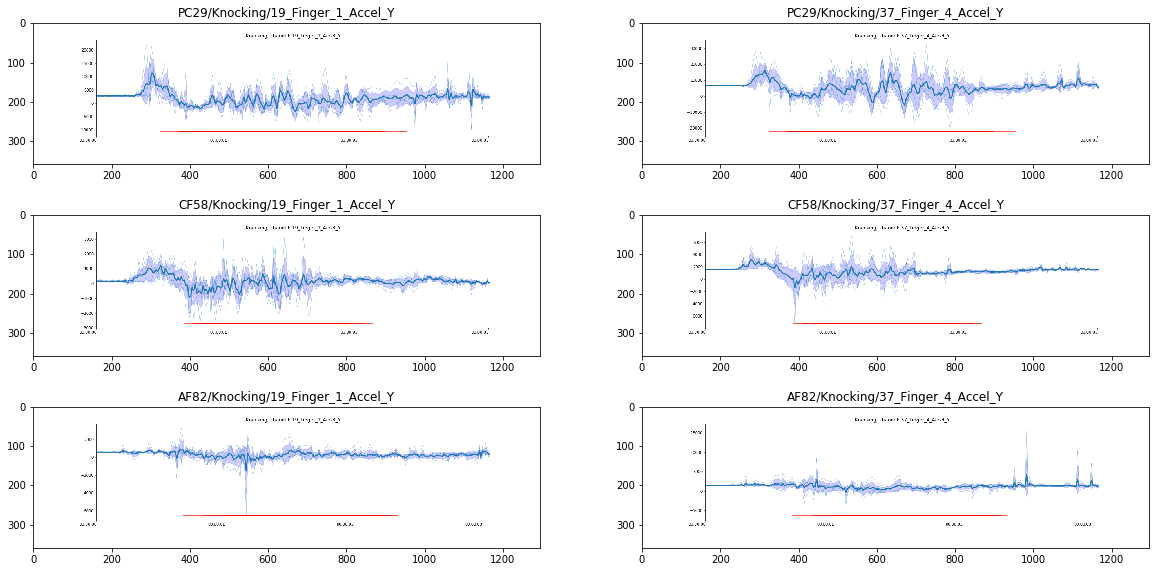

In [15]:
ud_helper.display_random_generated_images(3,1,2)

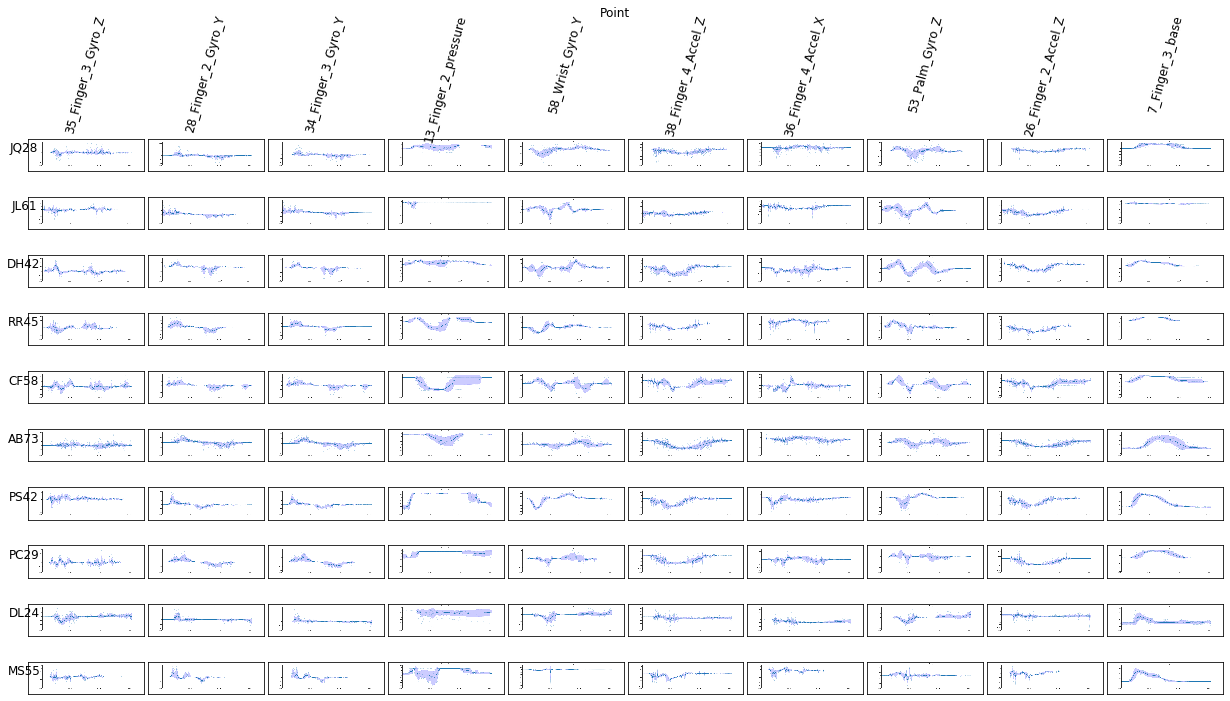

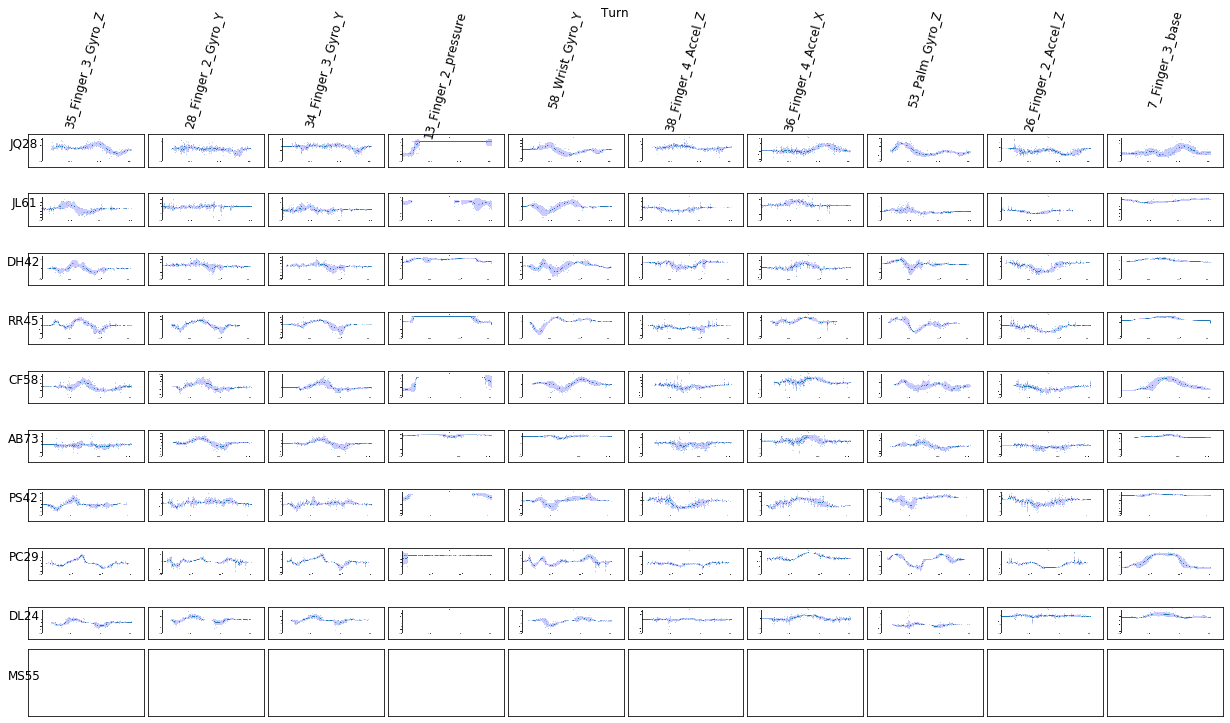

In [36]:
ud_helper.display_random_generated_images(10,2,10)

Given the differences it would be interesting to see what the default template for a gesture over all users look

In [10]:
collector = iutils.AllUsersCollector()
callback, skippable = gci.generate_visualize_all_channel_gesture_combinations_using_all_users_callback(
    users, collector, True)
skippable.mute()
ud_helper.iterate_users_of_gestures(callback)
template = gci.ChannelVisTemplate()
print(collector.current_gesture)
path = iutils.generate_img_base_path('all_users', collector.current_gesture, tqdm.tqdm_notebook([]))
template.visualize_gesture(path, collector.current_gesture, collector.instances_of_all_users, 
                           collector.groups_of_all_users, skippable)
skippable.report()

skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
(2) Two



skipped #723 image generations


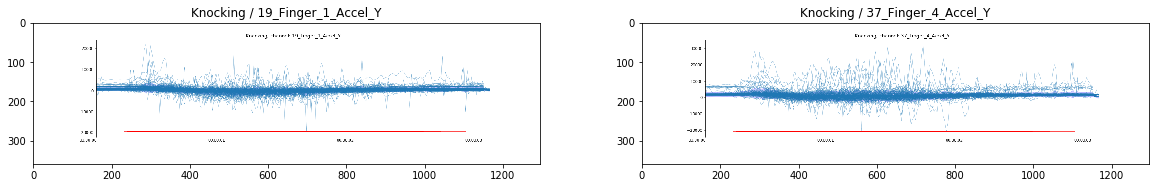

In [38]:
f, axarr = plt.subplots(1, 2, figsize=(20, 10))

axarr[0].set_title(f'Knocking / 19_Finger_1_Accel_Y')
path = f'../figures/raw/all_users/Knocking/19_Finger_1_Accel_Y.png'
a = mpimg.imread(path)
axarr[0].imshow(a)

axarr[1].set_title(f'Knocking / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users/Knocking/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1].imshow(a)

plt.show()

If we look at that result we can see that over all user the start times within an autmatic label varies a lot, and because the peaks then for a movement happen at different times the whole timeseries looks way more chaotic. Still there is more activity going on within the timeframe than outside. In a perfect world the real gesture would always start the same time. If we do that let's see if we get a different image.

In [11]:
collector = iutils.AllUsersCollector()
callback, skippable = gci.generate_visualize_all_channel_gesture_combinations_using_all_users_timealigned_callback(
    users, collector, True)
skippable.mute()
ud_helper.iterate_users_of_gestures(callback)
template = gci.ChannelVisTemplate()
path = iutils.generate_img_base_path('all_users_timealigned', collector.current_gesture, tqdm.tqdm_notebook([]))
template.visualize_gesture(path, collector.current_gesture, collector.instances_of_all_users, 
                           collector.groups_of_all_users, skippable)
skippable.report()

skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30



skipped #723 image generations


We can see that if the manual time starts the same the patterns get a bit clearer. F.e. in Finger 4 Accel Y we can se a relative clear pattern of up and down movements the knocking gesture consists of.

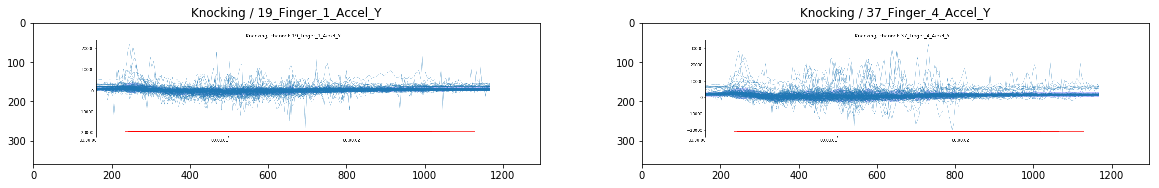

In [40]:
f, axarr = plt.subplots(1, 2, figsize=(20, 10))

axarr[0].set_title(f'Knocking / 19_Finger_1_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Knocking/19_Finger_1_Accel_Y.png'
a = mpimg.imread(path)
axarr[0].imshow(a)

axarr[1].set_title(f'Knocking / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Knocking/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1].imshow(a)

plt.show()

We now compared the difference in channels for the same gesture among different users or over all users. Another interesting question is, is there a difference for the channel among different gestures. If we f.e. compare some gestures (I took a random selection of Knocking, Weving, Thumbs up and Shoot) for Y Acceleration of Finger 4 we in fact do see very different patterns.

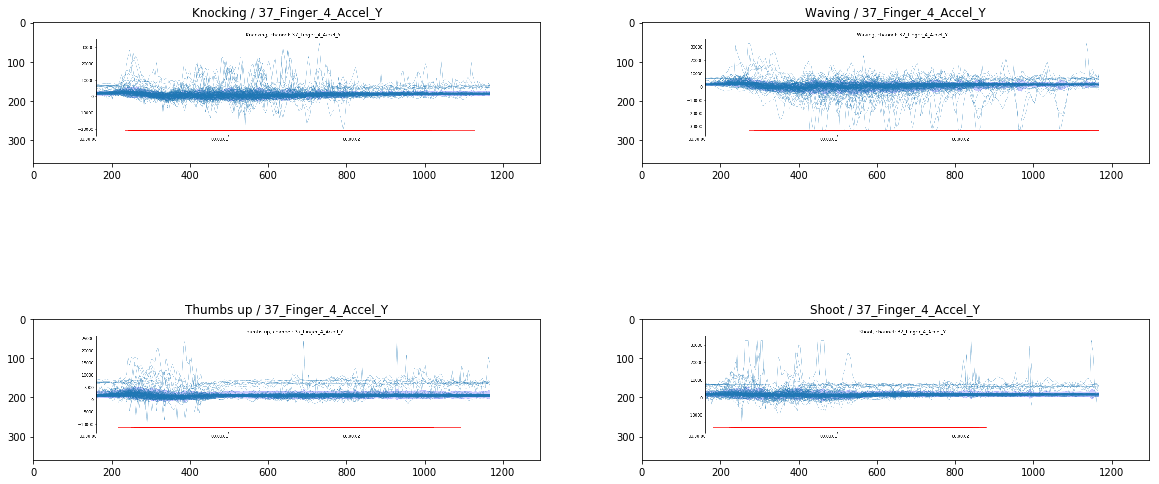

In [41]:
f, axarr = plt.subplots(2, 2, figsize=(20, 10))

axarr[0, 0].set_title(f'Knocking / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Knocking/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[0, 0].imshow(a)

axarr[0, 1].set_title(f'Waving / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Waving/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[0, 1].imshow(a)

axarr[1, 0].set_title(f'Thumbs up / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Thumbs up/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1, 0].imshow(a)

axarr[1, 1].set_title(f'Shoot / 37_Finger_4_Accel_Y')
path = f'../figures/raw/all_users_timealigned/Shoot/37_Finger_4_Accel_Y.png'
a = mpimg.imread(path)
axarr[1, 1].imshow(a)

plt.show()

In [ ]:
# visualization: what can we do here?
# plot labels with similar avarage raw signals
# 
# plot zero label examples near raw signals

# all for one random user or over all users:

# TODO: since all these things need long time: 
# - First make sure I can run them without a notebook (so there is also a scribt)
# - Secend, even more imporant: Make a function out of it, and control with a parameter overwrite
#   if it actually really recreates the picture if on is already there or not

In [12]:
ghi.generate_all_timing_histograms(users, ud_helper)

skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30
skipped #714 image generations


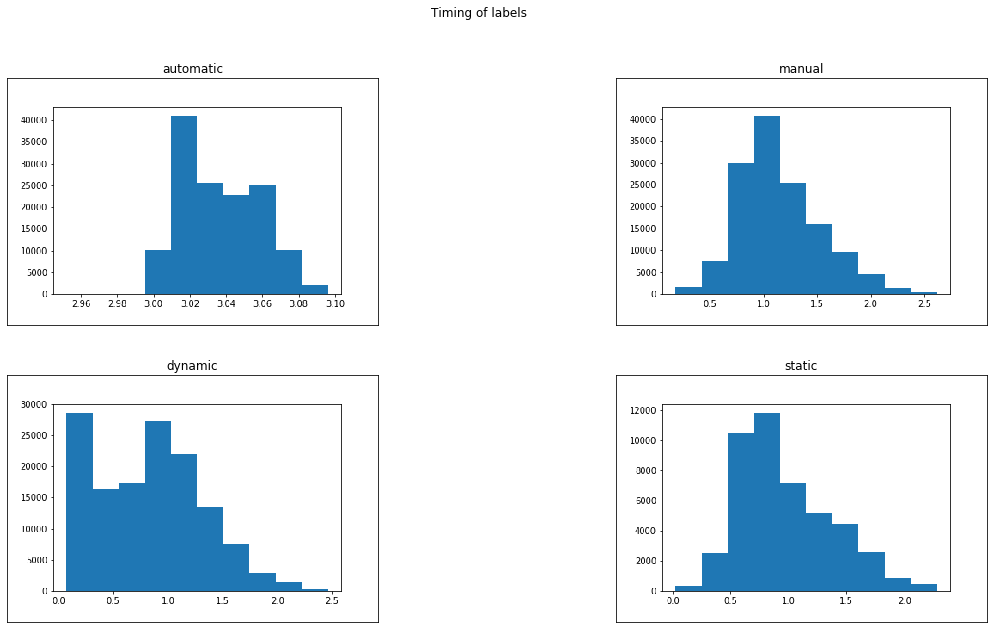

In [43]:
f, axarr = plt.subplots(2, 2, figsize=(20, 10))

axarr[0, 0].set_title(f'automatic')
path = f'../figures/raw/all_users/all_gestures/timing_of_automatic.png'
a = mpimg.imread(path)
axarr[0, 0].imshow(a)
iutils.hide_ticks_in_grid(0,0,axarr)

axarr[0, 1].set_title(f'manual')
path = f'../figures/raw/all_users/all_gestures/timing_of_manual.png'
a = mpimg.imread(path)
axarr[0, 1].imshow(a)
iutils.hide_ticks_in_grid(0,1,axarr)

axarr[1, 0].set_title(f'dynamic')
path = f'../figures/raw/all_users/all_gestures/timing_of_dynamic.png'
a = mpimg.imread(path)
axarr[1, 0].imshow(a)
iutils.hide_ticks_in_grid(1,0,axarr)

axarr[1, 1].set_title(f'static')
path = f'../figures/raw/all_users/all_gestures/timing_of_static.png'
a = mpimg.imread(path)
axarr[1, 1].imshow(a)
iutils.hide_ticks_in_grid(1,1,axarr)

plt.suptitle('Timing of labels')

plt.show()

#### Value Ranges

Next we look at the value ranges for each Channel/Sensor in the Dataset. This can enable us to deal with outliers, and look on a very high level on differences between users.

TODO: For the overall distribution of values in the chanels, make t-tests and so to compare them...

In [13]:
cols = users['AB73']['glove_merged'].columns
all_accel = Constants().raw_indices['accel']
print(cols[all_accel])

Index(['18_Finger_1_Accel_X', '19_Finger_1_Accel_Y', '20_Finger_1_Accel_Z',
       '24_Finger_2_Accel_X', '25_Finger_2_Accel_Y', '26_Finger_2_Accel_Z',
       '30_Finger_3_Accel_X', '31_Finger_3_Accel_Y', '32_Finger_3_Accel_Z',
       '36_Finger_4_Accel_X', '37_Finger_4_Accel_Y', '38_Finger_4_Accel_Z',
       '42_Thumb_Accel_X', '43_Thumb_Accel_Y', '44_Thumb_Accel_Z',
       '48_Palm_Accel_X', '49_Palm_Accel_Y', '50_Palm_Accel_Z',
       '54_Wrist_Accel_X', '55_Wrist_Accel_Y', '56_Wrist_Accel_Z'],
      dtype='object')


In [14]:
higher_percentile = 98.5
lower_percentile = 1.5

In [15]:
def describe_value_range(columes, remove_outliers, show_overal):
    def describe_values(line, username):
        print('user: ', username)
        print(pd.DataFrame(data=line).describe())
        print("")
    all_vals = sutils.collect_values(usernames, users, columes, remove_outliers, 
                                     higher_percentile, lower_percentile, 
                                     True, describe_values, use_tqtm=True)
    if show_overal:
        print(pd.DataFrame(data=all_vals).describe())

In [16]:
idx_keys = Constants().raw_indices.keys()
print(idx_keys)

dict_keys(['flex', 'pressure', 'accel', 'gyro', 'magnetometer', 'lin_accel', 'thumb', 'finger_1', 'finger_2', 'finger_3', 'finger_4', 'wrist', 'palm'])


In [12]:
describe_value_range(cols[all_accel], True, False)

user:  AB73
                  0
count  3.843168e+06
mean   4.253109e+02
std    1.096032e+03
min   -2.247000e+03
25%   -5.920000e+02
50%    6.710000e+02
75%    1.346000e+03
max    2.313000e+03

skipping userAE30
user:  AF82
                  0
count  2.222535e+06
mean   3.296671e+02
std    1.114297e+03
min   -2.098000e+03
25%   -7.140000e+02
50%    3.770000e+02
75%    1.424000e+03
max    2.208000e+03

user:  AL29
                  0
count  3.869796e+06
mean   4.380956e+02
std    1.079509e+03
min   -2.031000e+03
25%   -5.490000e+02
50%    4.100000e+02
75%    1.501000e+03
max    2.293000e+03

user:  AW18
                  0
count  2.166339e+06
mean   3.938461e+02
std    1.110300e+03
min   -2.305000e+03
25%   -5.030000e+02
50%    5.940000e+02
75%    1.287000e+03
max    2.338000e+03

user:  CB23
                  0
count  2.211951e+06
mean   5.256775e+02
std    1.062236e+03
min   -2.179000e+03
25%   -2.490000e+02
50%    4.340000e+02
75%    1.520000e+03
max    2.353000e+03

user:  CB24
     

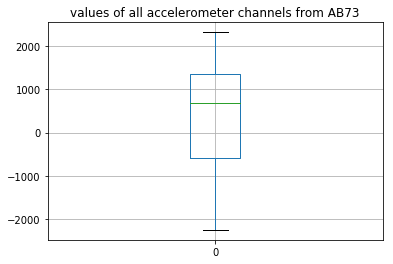

skipping userAE30


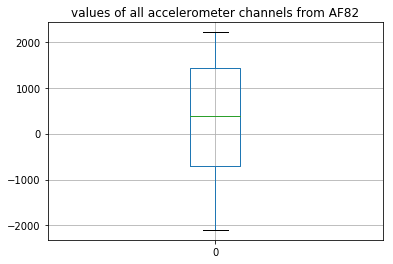

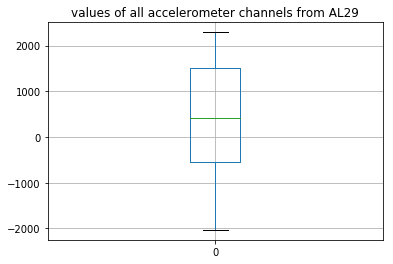

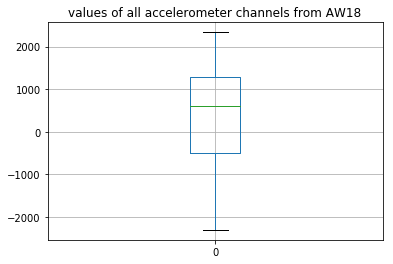

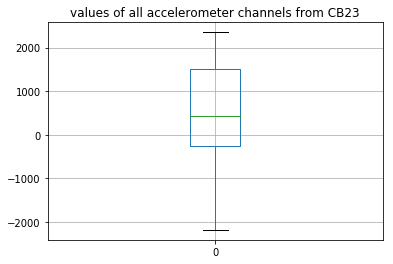

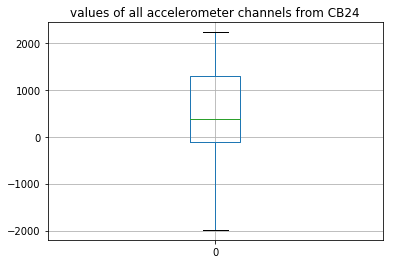

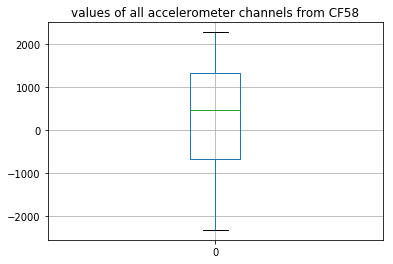

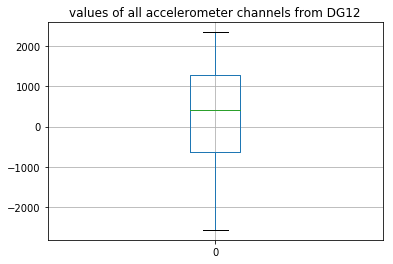

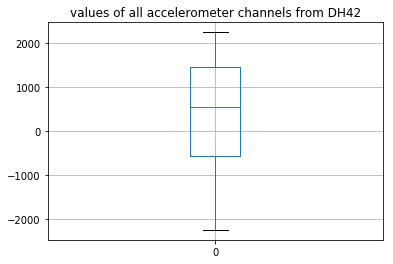

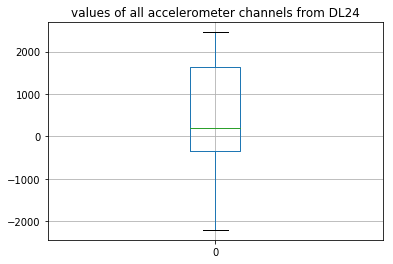

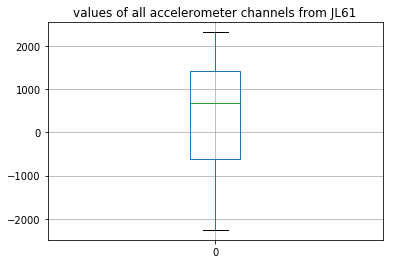

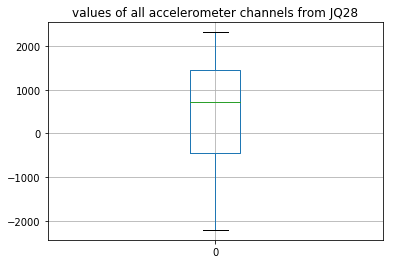

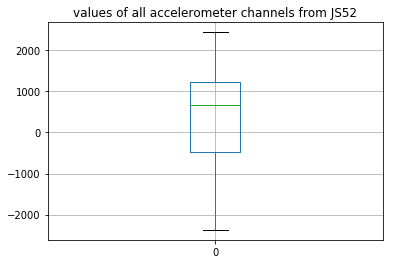

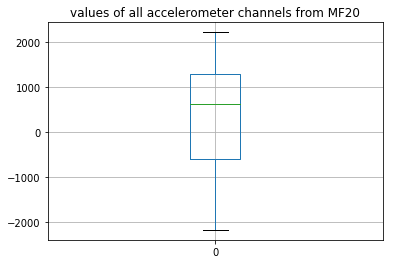

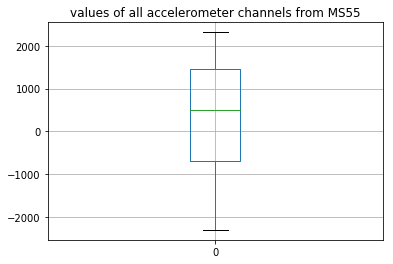

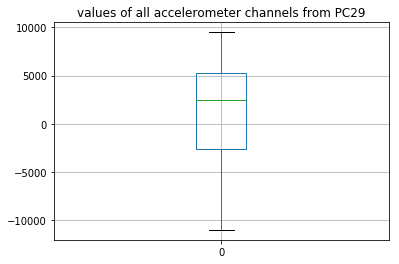

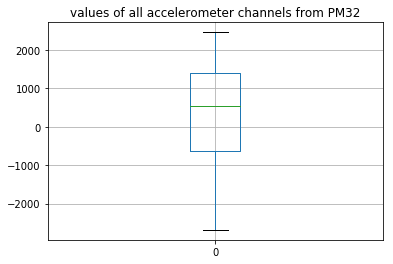

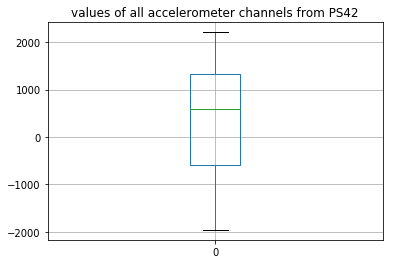

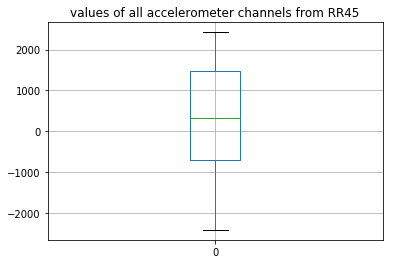

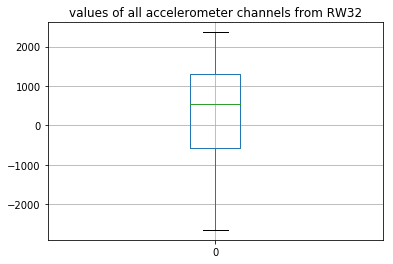

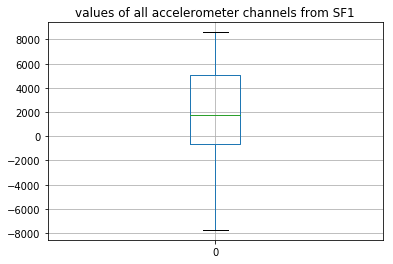

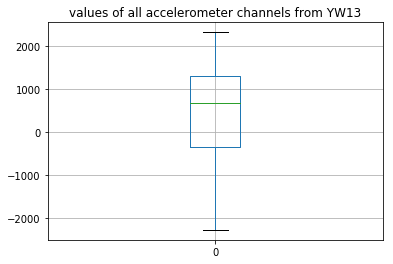

In [56]:
gbo.show_valuerange_individual_boxplots(usernames, users, 'all accelerometer channels', cols[all_accel], 
                                        True, higher_percentile, lower_percentile, False, False)

In [57]:
all_gyro = Constants().raw_indices['gyro']
print(cols[all_gyro])

Index(['21_Finger_1_Gyro_X', '22_Finger_1_Gyro_Y', '23_Finger_1_Gyro_Z',
       '27_Finger_2_Gyro_X', '28_Finger_2_Gyro_Y', '29_Finger_2_Gyro_Z',
       '33_Finger_3_Gyro_X', '34_Finger_3_Gyro_Y', '35_Finger_3_Gyro_Z',
       '39_Finger_4_Gyro_X', '40_Finger_4_Gyro_Y', '41_Finger_4_Gyro_Z',
       '45_Thumb_Gyro_X', '46_Thumb_Gyro_Y', '47_Thumb_Gyro_Z',
       '51_Palm_Gyro_X', '52_Palm_Gyro_Y', '53_Palm_Gyro_Z', '57_Wrist_Gyro_X',
       '58_Wrist_Gyro_Y', '59_Wrist_Gyro_Z'],
      dtype='object')


In [60]:
describe_value_range(cols[all_gyro], True, False)

user:  AB73
                  0
count  3.843168e+06
mean  -1.524872e+01
std    7.369976e+02
min   -3.623000e+03
25%   -4.300000e+01
50%   -1.000000e+00
75%    3.800000e+01
max    3.490000e+03

skipping userAE30
user:  AF82
                  0
count  2.222535e+06
mean  -1.009352e+01
std    6.580186e+02
min   -3.211000e+03
25%   -4.300000e+01
50%   -3.000000e+00
75%    3.100000e+01
max    3.287000e+03

user:  AL29
                  0
count  3.869796e+06
mean  -1.501949e+01
std    6.743646e+02
min   -3.154000e+03
25%   -4.200000e+01
50%   -3.000000e+00
75%    3.000000e+01
max    3.172000e+03

user:  AW18
                  0
count  2.166339e+06
mean  -1.664590e+01
std    6.459756e+02
min   -3.408000e+03
25%   -3.700000e+01
50%   -3.000000e+00
75%    3.300000e+01
max    3.081000e+03

user:  CB23
                  0
count  2.211951e+06
mean  -1.660161e+01
std    5.905053e+02
min   -2.990000e+03
25%   -5.300000e+01
50%   -7.000000e+00
75%    4.400000e+01
max    2.667000e+03

user:  CB24
     

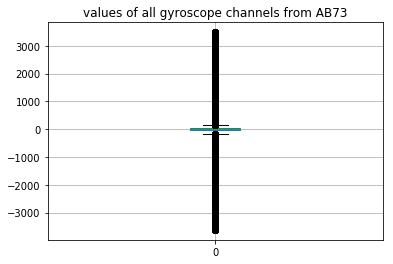

skipping userAE30


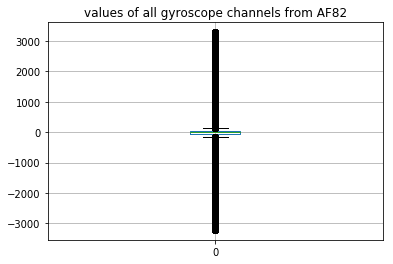

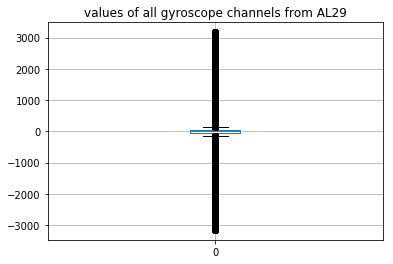

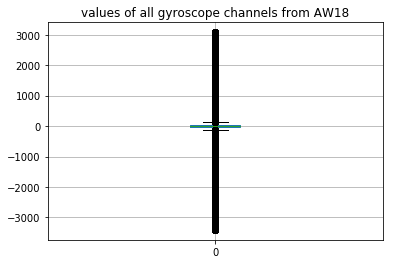

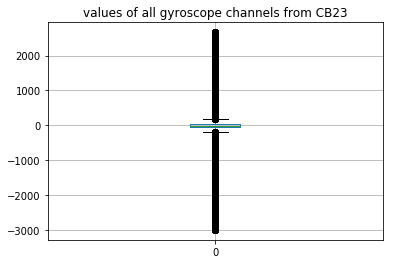

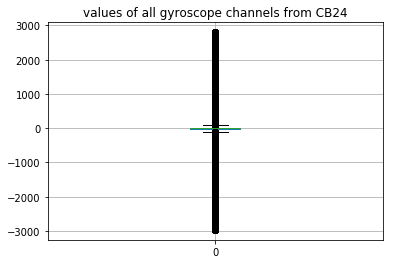

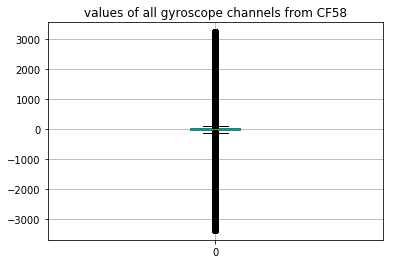

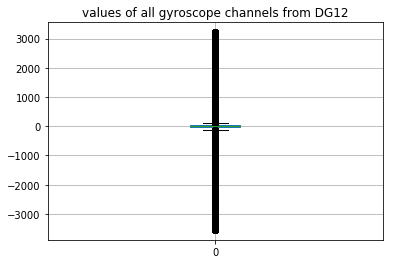

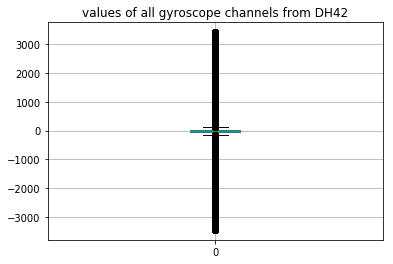

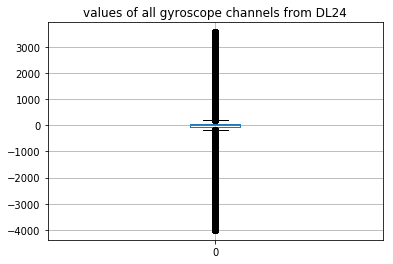

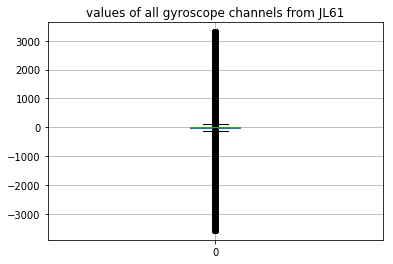

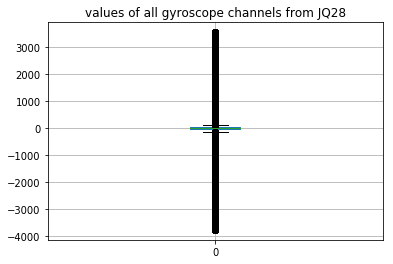

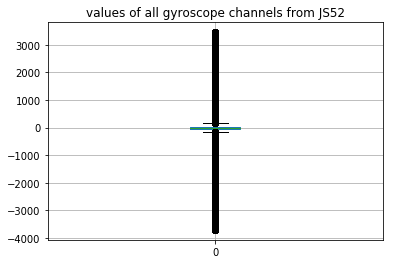

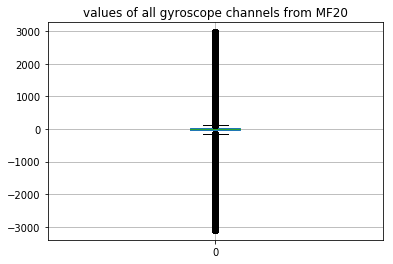

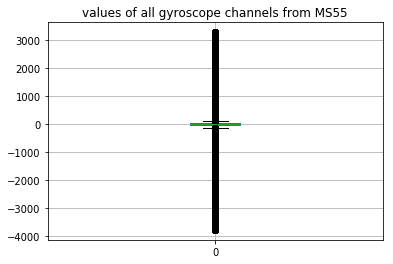

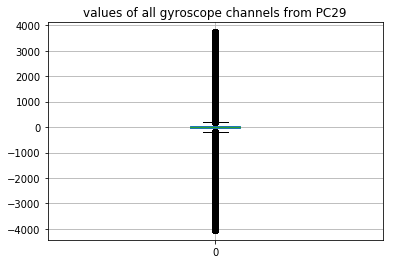

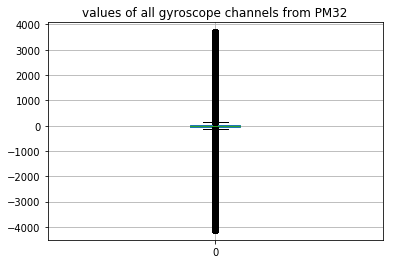

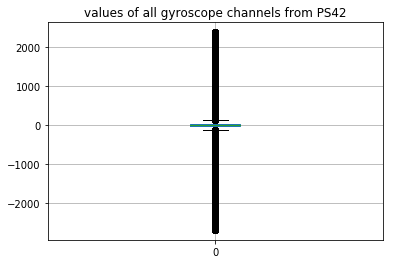

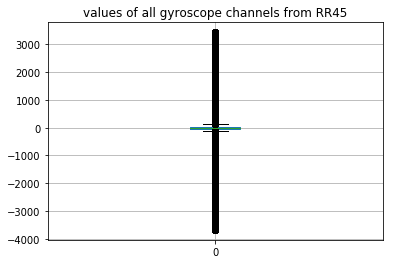

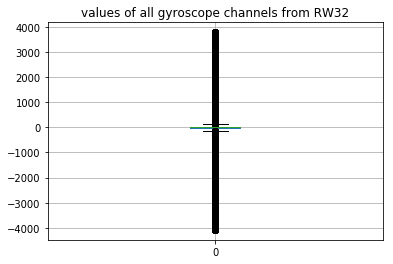

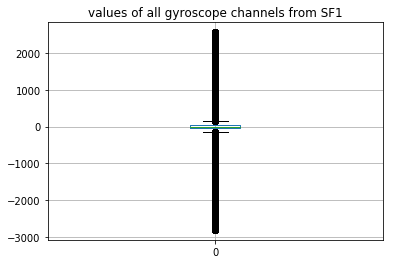

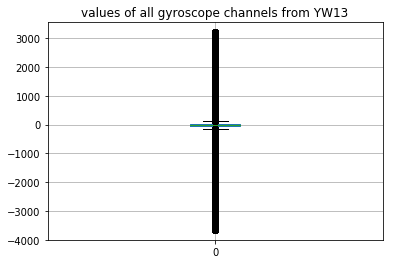

In [61]:
gbo.show_valuerange_individual_boxplots(usernames, users, 'all gyroscope channels', cols[all_gyro], 
                                        True, higher_percentile, lower_percentile, False, False)

In [62]:
all_flex = Constants().raw_indices['flex']['all']
print(cols[all_flex])

Index(['0_Thumb_base', '2_Angle_between_thumb_and_hand', '3_Finger_1_base',
       '4_Finger_1_tip', '5_Finger_2_base', '6_Finger_2_tip',
       '7_Finger_3_base', '8_Finger_3_tip', '9_Finger_4_base',
       '10_Finger_4_tip', '11_Thumb_tip', '16_Wrist_extension',
       '17_Wrist_flexion'],
      dtype='object')


In [63]:
describe_value_range(cols[all_flex], True, False)

user:  AB73
                  0
count  2.379104e+06
mean   1.772701e+03
std    2.868182e+02
min    1.136000e+03
25%    1.624000e+03
50%    1.803000e+03
75%    1.975000e+03
max    2.314000e+03

skipping userAE30
user:  AF82
                  0
count  1.375855e+06
mean   1.755300e+03
std    2.675732e+02
min    1.162000e+03
25%    1.629000e+03
50%    1.759000e+03
75%    1.931000e+03
max    2.282000e+03

user:  AL29
                  0
count  2.395588e+06
mean   1.698773e+03
std    2.545248e+02
min    1.166000e+03
25%    1.592000e+03
50%    1.718000e+03
75%    1.857000e+03
max    2.222000e+03

user:  AW18
                  0
count  1.341067e+06
mean   1.709894e+03
std    2.943142e+02
min    1.093000e+03
25%    1.600000e+03
50%    1.725000e+03
75%    1.909000e+03
max    2.250000e+03

user:  CB23
                  0
count  1.369303e+06
mean   1.754792e+03
std    3.325143e+02
min    1.039000e+03
25%    1.623000e+03
50%    1.806000e+03
75%    1.997000e+03
max    2.309000e+03

user:  CB24
     

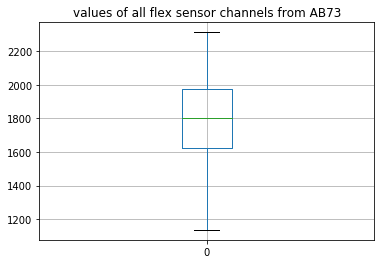

skipping userAE30


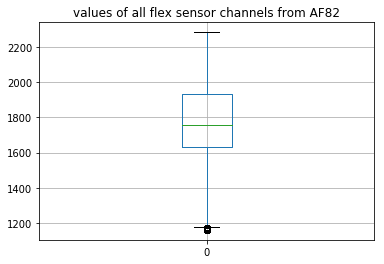

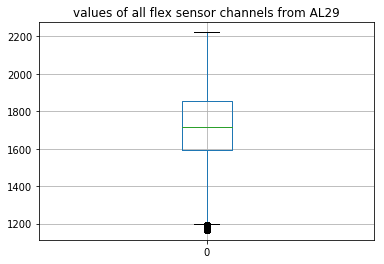

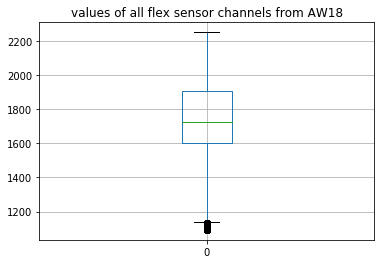

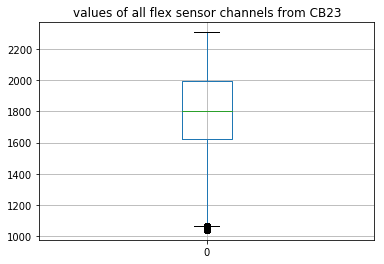

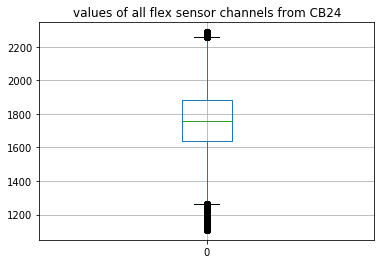

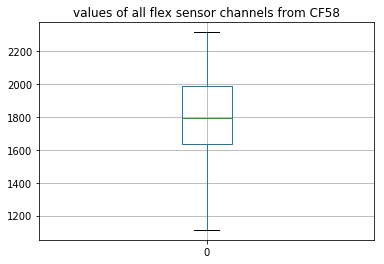

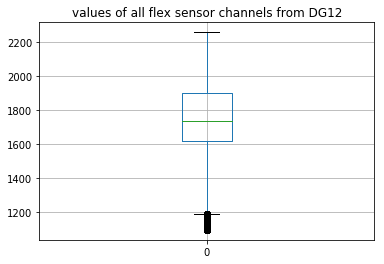

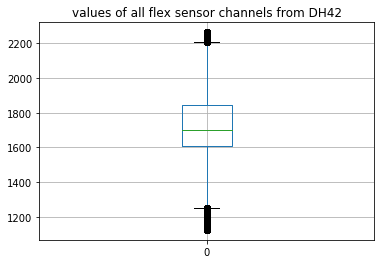

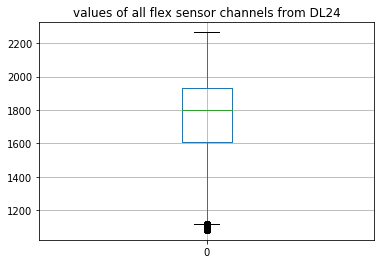

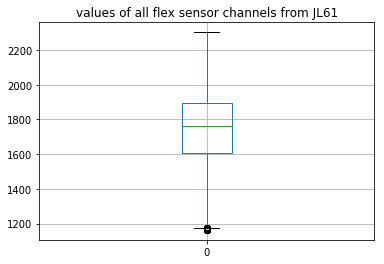

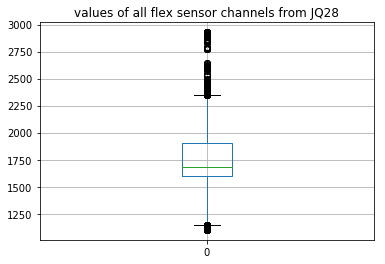

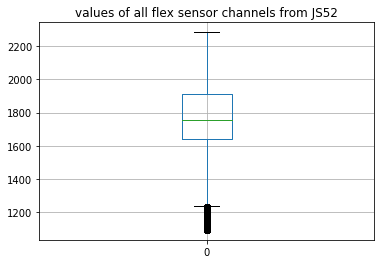

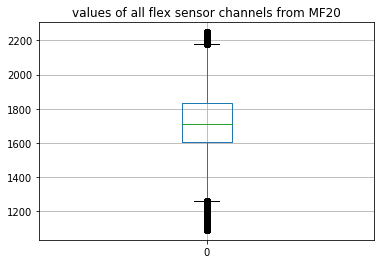

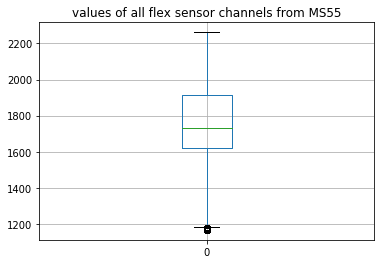

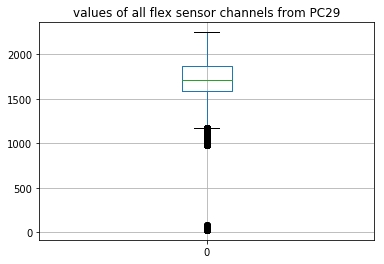

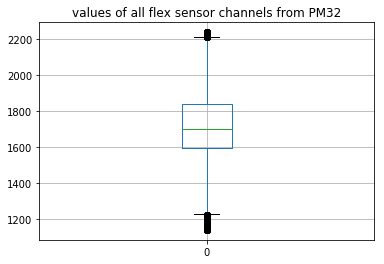

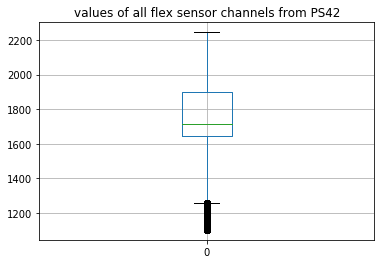

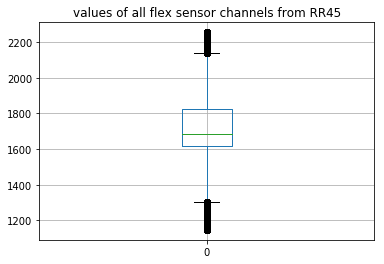

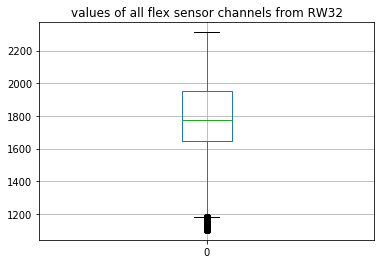

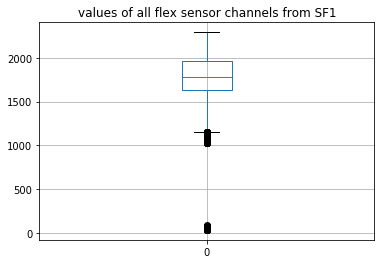

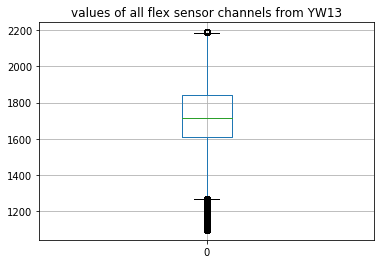

In [64]:
gbo.show_valuerange_individual_boxplots(usernames, users, 'all flex sensor channels', cols[all_flex], 
                                        True, higher_percentile, lower_percentile, False, False)

skipping userAE30


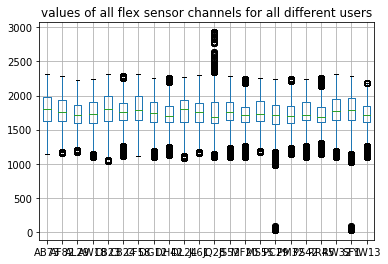

In [66]:
gbo.show_valuerange_boxplots_in_one_image(usernames, users, 'all flex sensor channels', cols[all_flex], 
                                        True, higher_percentile, lower_percentile, False, False)

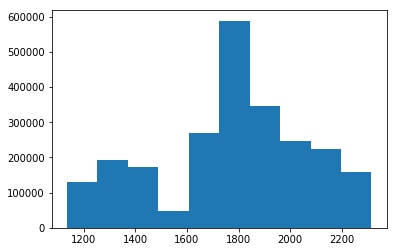

skipping userAE30


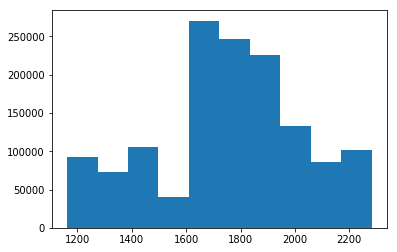

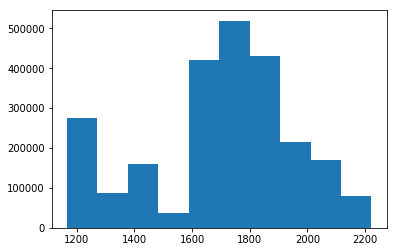

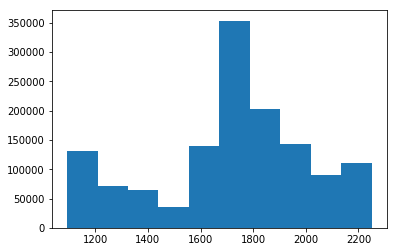

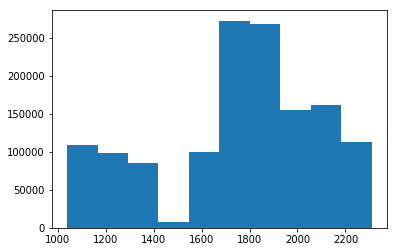

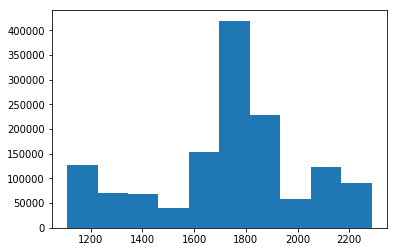

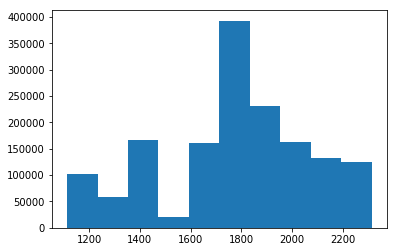

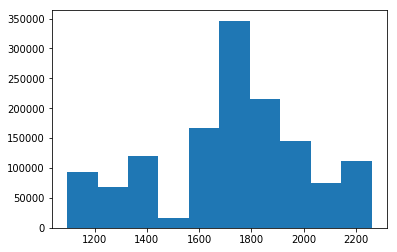

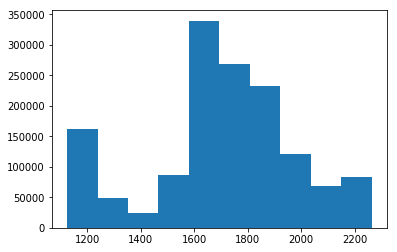

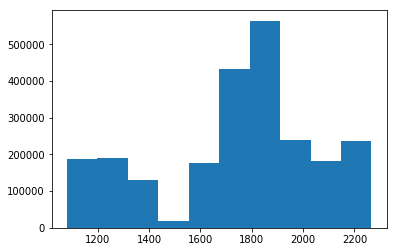

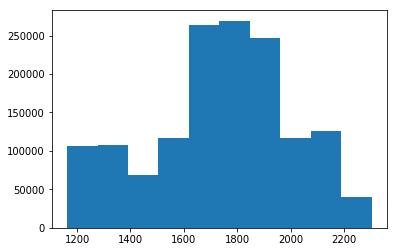

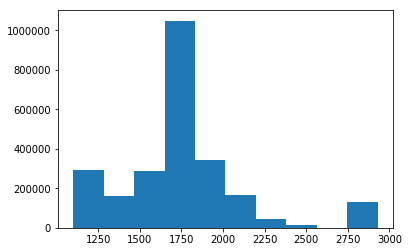

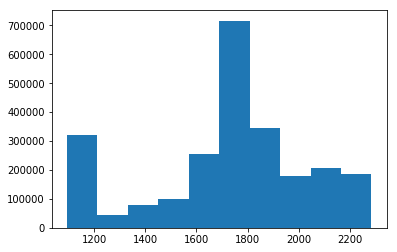

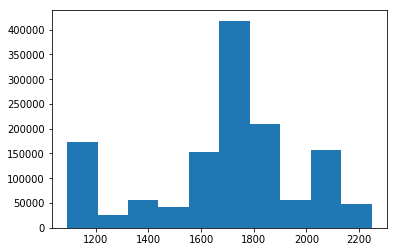

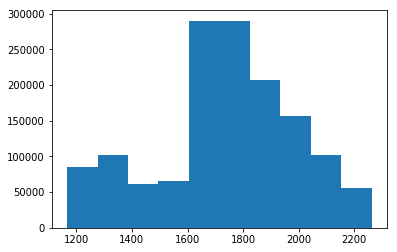

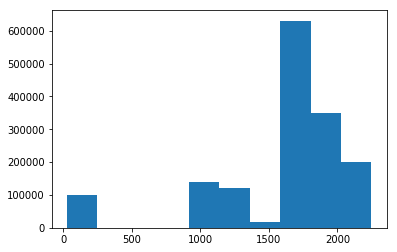

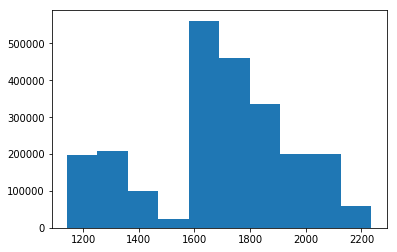

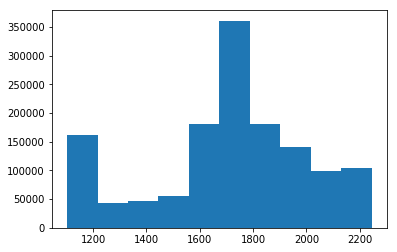

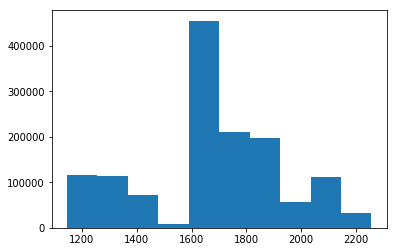

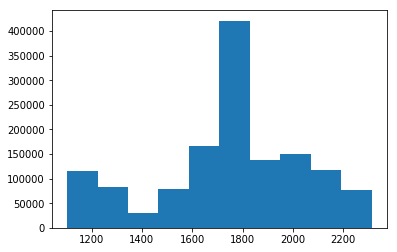

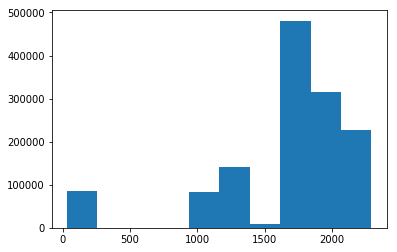

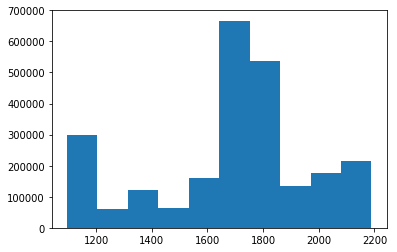

In [67]:
ghi.show_valuerange_histograms(usernames, users, cols[all_flex], 
                               True, higher_percentile, lower_percentile, 
                               False, False)

In [ ]:
# so, the next step in the story is this: 
# Are these variations mainly the 0 class or mainly the 
# way gestures are done?
# 
# To prove that I seperate the data into clearly 0 class 
# instances (everything outside the automatic) labeling,
# and into clearly geatures (everything inside the manual
# labeling)

skipping userAE30


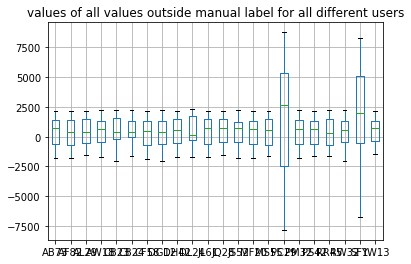

In [70]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values outside manual label', cols[all_accel], 
    'label_manual', 'zero_class', True, higher_percentile, lower_percentile, False, False)

skipping userAE30


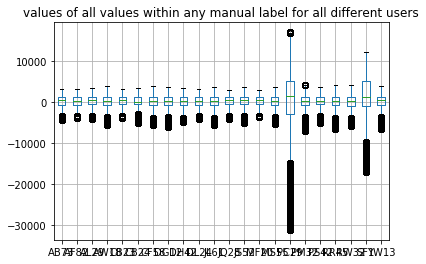

In [69]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values within any manual label', cols[all_accel], 
    'label_manual', 'all_labels', True, higher_percentile, lower_percentile, False, False)
#show_boxplots_row_lc(cols[all_accel], 'label_manual', 'all_labels', True, False)

### Test vor Normal Distribution

The values of the sensors overall and for gestures seems to be normal distributed in the large. To thest for that I perform a D’Agostino and Pearson’s test for the values distribution of each individual sensor and the distribution of sensor - gesture pairs. The results are summariezed in the following Table:

We use:
(1, 2) D’Agostino, R. B. (1971), “An omnibus test of normality for moderate and large sample size”, Biometrika, 58, 341-348
[2]	(1, 2) D’Agostino, R. and Pearson, E. S. (1973), “Tests for departure from normality”, Biometrika, 60, 613-622

In [47]:
def print_for_console(uname, vmin, vmax, n, k2, p):
    print(f'user: {uname}')
    print(f'n: {n}, min: {vmin:e}, max: {vmax:e}')
    print(f'k2: {k2:e} p = {p:e}')

def print_table_markdown_header():
    print(f'| Name | N | Min | Max | K2 | P |')
    print(f'| ---- | - | --- | --- | -- | - |')

def print_table_for_markdown(uname, vmin, vmax, n, k2, p):
    print(f'| {uname} | {n:e}  | {vmin:e} | {vmax:e} | {k2:e} | {p:e} |')

In [51]:
#print_table_markdown_header()
vals = values_per_user(cols[all_accel], True, True)
for v, u in vals:
    vmin, vmax = v.min(), v.max()
    n = len(v)
    k2, p = sp.stats.normaltest(v)
    #print_table_for_markdown(u, vmin, vmax, n, k2, p)
    print_for_console(u, vmin, vmax, n, k2, p)

user: AB73
n: 3843168, min: -2.247000e+03, max: 2.313000e+03
k2: 1.332371e+06 p = 0.000000e+00
skipping userAE30
user: AF82
n: 2222535, min: -2.098000e+03, max: 2.208000e+03
k2: 3.965770e+06 p = 0.000000e+00
user: AL29
n: 3869796, min: -2.031000e+03, max: 2.293000e+03
k2: 3.432655e+08 p = 0.000000e+00
user: AW18
n: 2166339, min: -2.305000e+03, max: 2.338000e+03
k2: 5.806311e+05 p = 0.000000e+00
user: CB23
n: 2211951, min: -2.179000e+03, max: 2.353000e+03
k2: 2.208363e+05 p = 0.000000e+00
user: CB24
n: 2227722, min: -1.986000e+03, max: 2.226000e+03
k2: 1.704378e+05 p = 0.000000e+00
user: CF58
n: 2505216, min: -2.330000e+03, max: 2.275000e+03
k2: 1.501297e+06 p = 0.000000e+00
user: DG12
n: 2195571, min: -2.559000e+03, max: 2.333000e+03
k2: 7.056697e+05 p = 0.000000e+00
user: DH42
n: 2319135, min: -2.253000e+03, max: 2.249000e+03
k2: 2.388734e+06 p = 0.000000e+00
user: DL24
n: 3806838, min: -2.205000e+03, max: 2.454000e+03
k2: 1.443842e+06 p = 0.000000e+00
user: JL61
n: 2363886, min: -2.2

The following table shows a test if the values of all accelerometer channels (each sensor, x,y,z taken together) are thrown together they are not even near a normal distribution for each user. So to compare them a non-parametric comparison must be taken.

| Name | N | Min | Max | K2 | P |
| ---- | - | --- | --- | -- | - |
| AB73 | 3.843168e+06  | -2.247000e+03 | 2.313000e+03 | 1.332371e+06 | 0.000000e+00 |
| AF82 | 2.222535e+06  | -2.098000e+03 | 2.208000e+03 | 3.965770e+06 | 0.000000e+00 |
| AL29 | 3.869796e+06  | -2.031000e+03 | 2.293000e+03 | 3.432655e+08 | 0.000000e+00 |
| AW18 | 2.166339e+06  | -2.305000e+03 | 2.338000e+03 | 5.806311e+05 | 0.000000e+00 |
| CB23 | 2.211951e+06  | -2.179000e+03 | 2.353000e+03 | 2.208363e+05 | 0.000000e+00 |
| CB24 | 2.227722e+06  | -1.986000e+03 | 2.226000e+03 | 1.704378e+05 | 0.000000e+00 |
| CF58 | 2.505216e+06  | -2.330000e+03 | 2.275000e+03 | 1.501297e+06 | 0.000000e+00 |
| DG12 | 2.195571e+06  | -2.559000e+03 | 2.333000e+03 | 7.056697e+05 | 0.000000e+00 |
| DH42 | 2.319135e+06  | -2.253000e+03 | 2.249000e+03 | 2.388734e+06 | 0.000000e+00 |
| DL24 | 3.806838e+06  | -2.205000e+03 | 2.454000e+03 | 1.443842e+06 | 0.000000e+00 |
| JL61 | 2.363886e+06  | -2.256000e+03 | 2.315000e+03 | 2.478691e+06 | 0.000000e+00 |
| JQ28 | 4.023516e+06  | -2.206000e+03 | 2.314000e+03 | 2.761341e+06 | 0.000000e+00 |
| JS52 | 3.936009e+06  | -2.372000e+03 | 2.440000e+03 | 8.583538e+05 | 0.000000e+00 |
| MF20 | 2.163441e+06  | -2.167000e+03 | 2.212000e+03 | 7.814999e+05 | 0.000000e+00 |
| MS55 | 2.285892e+06  | -2.308000e+03 | 2.320000e+03 | 4.337789e+06 | 0.000000e+00 |
| PC29 | 2.522898e+06  | -1.098600e+04 | 9.480000e+03 | 6.032791e+05 | 0.000000e+00 |
| PM32 | 3.794028e+06  | -2.685000e+03 | 2.465000e+03 | 1.420897e+06 | 0.000000e+00 |
| PS42 | 2.221695e+06  | -1.959000e+03 | 2.208000e+03 | 4.562585e+06 | 0.000000e+00 |
| RR45 | 2.218671e+06  | -2.419000e+03 | 2.423000e+03 | 5.364713e+06 | 0.000000e+00 |
| RW32 | 2.222241e+06  | -2.656000e+03 | 2.364000e+03 | 3.347358e+05 | 0.000000e+00 |
| SF1  | 2.167305e+06  | -7.738000e+03 | 8.598000e+03 | 2.609429e+05 | 0.000000e+00 |
| YW13 | 3.928722e+06  | -2.283000e+03 | 2.316000e+03 | 1.276646e+06 | 0.000000e+00 |


In fact, if we test the distribution of the pure values for each individual channel for each user, than all of them are not even nearly normal distributed. With a null hypthesis that they are normal distributet, the students t-test gives a p value below 0.001 for each of them beside the Thumb base flex sensor of user AE30, who still is significantly not-normal as the p value is 0.02385297 which is still below 0.05

In [55]:
#print_table_markdown_header()
# test each channel in the data if it is not normal distibuted:
alpha = 0.001
for c in cols[:-7]:
    vals = values_per_user(c, True, True)
    for v, u in vals:
        vmin, vmax = v.min(), v.max()
        n = len(v)
        k2, p = sp.stats.normaltest(v)
        if p > alpha:
            print('maybe normal: ', c)
            print_for_console(u, vmin, vmax, n, k2, p)

skipping userAE30
maybe normal:  0_Thumb_base
user: DG12
n: 104551, min: 1.689000e+03, max: 1.916000e+03
k2: 7.471693e+00 p = 2.385297e-02


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


skipping userAE30


In [35]:
len(all_accel)

21

It is interesting to compare the distributions of the overal data between the zero class and the individual gestures for each sensor. Since we have prooven that these data is not normal distributed we need another means to compare these data. Several options exist: The Kolmogorov–Smirnov test in form of the two-sample K–S test, the Anderson–Darling test as a K-Sample Anderson–Darling test, the Kuiper's test and maybe others. The Kolmogorov–Smirnov is realively well esteblished to make pairwise comparison, which is what I want to do, so we choose this one.

In [27]:
vpu = functools.partial(sutils.values_per_user, remove_outliers=True,
                    higher_percentile=higher_percentile, lower_percentile=lower_percentile, use_tqtm=False)

for c1 in cols[:-7]:
    for c2 in cols[:-7]:
        for u in usernames:
            users[u][f'{c1}-{c2}'] = []

for c1 in cols[:-7]:
    for c2 in cols[:-7]:
        print('--------------------------')
        print(f'channel {c1} <-> channel {c2}')
        val1 = vpu(usernames, users, c1)
        val2 = vpu(usernames, users, c2)
        for (v1, u1), (v2, u2) in zip(val1, val2):
            if u1 != u2:
                print('user different?', u1, u2)
                continue
            users[u1][f'{c1}-{c2}'].append(sp.stats.ks_2samp(v1, v2))

--------------------------
channel 0_Thumb_base <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 8_Finger_3_tip
skipping userAE30


--------------------------
channel 1_Thumb_pressure <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure 

--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_han

--------------------------
channel 3_Finger_1_base <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-

--------------------------
channel 4_Finger_1_tip <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channe

--------------------------
channel 5_Finger_2_base <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base 

--------------------------
channel 6_Finger_2_tip <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 47_Thumb_Gyro_

--------------------------
channel 7_Finger_3_base <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 55_Wrist_Accel_Y
sk

--------------------------
channel 8_Finger_3_tip <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 9_Finger_4_base <-> channel 0_Thumb_base
skip

--------------------------
channel 10_Finger_4_tip <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 8_Fing

--------------------------
channel 11_Thumb_tip <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 16_Wrist_extension
skipping 

--------------------------
channel 12_Finger_1_pressure <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
---------------

--------------------------
channel 13_Finger_2_pressure <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
-------------

--------------------------
channel 14_Finger_3_pressure <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
------------

--------------------------
channel 15_Finger_4_pressure <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
-----------

--------------------------
channel 16_Wrist_extension <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channe

--------------------------
channel 17_Wrist_flexion <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 50_Pa

--------------------------
channel 18_Finger_1_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Ac

--------------------------
channel 19_Finger_1_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger

--------------------------
channel 20_Finger_1_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
chann

--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finge

--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_

--------------------------
channel 24_Finger_2_Accel_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
-----------------

--------------------------
channel 25_Finger_2_Accel_Y <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
-------------------

--------------------------
channel 26_Finger_2_Accel_Z <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------

--------------------------
channel 27_Finger_2_Gyro_X <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
ch

--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
ch

--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_

--------------------------
channel 30_Finger_3_Accel_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Acc

--------------------------
channel 31_Finger_3_Accel_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_A

--------------------------
channel 32_Finger_3_Accel_Z <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 33_Fi

--------------------------
channel 33_Finger_3_Gyro_X <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 33_Finger_3_Gyro_X <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Fi

--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> chan

--------------------------
channel 36_Finger_4_Accel_X <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 37_Finger_4_Accel_Y <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
---------------------

--------------------------
channel 38_Finger_4_Accel_Z <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------

--------------------------
channel 39_Finger_4_Gyro_X <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4

--------------------------
channel 42_Thumb_Accel_X <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 51_Pal

--------------------------
channel 43_Thumb_Accel_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 58_Wrist

--------------------------
channel 44_Thumb_Accel_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 2_Angle

--------------------------
channel 46_Thumb_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 10_Fi

--------------------------
channel 47_Thumb_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> chan

--------------------------
channel 48_Palm_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <->

--------------------------
channel 49_Palm_Accel_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y 

--------------------------
channel 50_Palm_Accel_Z <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z 

--------------------------
channel 51_Palm_Gyro_X <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 47_Thumb_Gyro_

--------------------------
channel 52_Palm_Gyro_Y <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 55_Wrist_Accel_Y
skipping us

--------------------------
channel 53_Palm_Gyro_Z <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 54_Wrist_Accel_X <-> channel 0_Thumb_base
ski

--------------------------
channel 54_Wrist_Accel_X <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> cha

--------------------------
channel 56_Wrist_Accel_Z <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 14_

--------------------------
channel 57_Wrist_Gyro_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_

--------------------------
channel 58_Wrist_Gyro_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <

--------------------------
channel 59_Wrist_Gyro_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-

--------------------------
channel 60_Magnetometer_X <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60

--------------------------
channel 61_Magnetometer_Y <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-

--------------------------
channel 62_Magnetometer_Z <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 54

In [30]:
# in case the script above worked, execute that line:
with open( stats_added_path_pickl, "wb" ) as users_pickle_file:
    pickle.dump(users, users_pickle_file)

In [ ]:
# in case you need to reload, and know it exists:
with open( stats_added_path_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

Since we computed the k-s statistic of each channel to each other we can display a heatmap with this data so show how different the channel distributions are avaraged over all users. A value of 0 means they are the same, a value of 1 means they are totally different. Since we compare value ranges with hundred thousands of values all differences come up as highly significant, so we obmit p-values (all are below 0.0e-15).

In [47]:
matrix = np.zeros((len(cols[:-7]), len(cols[:-7])))

for u in usernames:
    if not 'glove_merged' in users[u]:
        print('skipping user' + u)
        continue
    for c1 in cols[:-7]:
        idx_1 = cols.get_loc(c1)
        for c2 in cols[:-7]:
            idx_2 = cols.get_loc(c2)
            stats = users[u][f'{c1}-{c2}'][0]
            matrix[idx_1, idx_2] += stats[0]
matrix = matrix / (len(usernames)-1.)

skipping userAE30


In [55]:
matrix

array([[0.        , 0.99594558, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99594558, 0.        , 0.99826636, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.99826636, 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.79629245,
        0.63601729],
       [1.        , 1.        , 1.        , ..., 0.79629245, 0.        ,
        0.77499439],
       [1.        , 1.        , 1.        , ..., 0.63601729, 0.77499439,
        0.        ]])

In [62]:
cols[:-7]

Index(['0_Thumb_base', '1_Thumb_pressure', '2_Angle_between_thumb_and_hand',
       '3_Finger_1_base', '4_Finger_1_tip', '5_Finger_2_base',
       '6_Finger_2_tip', '7_Finger_3_base', '8_Finger_3_tip',
       '9_Finger_4_base', '10_Finger_4_tip', '11_Thumb_tip',
       '12_Finger_1_pressure', '13_Finger_2_pressure', '14_Finger_3_pressure',
       '15_Finger_4_pressure', '16_Wrist_extension', '17_Wrist_flexion',
       '18_Finger_1_Accel_X', '19_Finger_1_Accel_Y', '20_Finger_1_Accel_Z',
       '21_Finger_1_Gyro_X', '22_Finger_1_Gyro_Y', '23_Finger_1_Gyro_Z',
       '24_Finger_2_Accel_X', '25_Finger_2_Accel_Y', '26_Finger_2_Accel_Z',
       '27_Finger_2_Gyro_X', '28_Finger_2_Gyro_Y', '29_Finger_2_Gyro_Z',
       '30_Finger_3_Accel_X', '31_Finger_3_Accel_Y', '32_Finger_3_Accel_Z',
       '33_Finger_3_Gyro_X', '34_Finger_3_Gyro_Y', '35_Finger_3_Gyro_Z',
       '36_Finger_4_Accel_X', '37_Finger_4_Accel_Y', '38_Finger_4_Accel_Z',
       '39_Finger_4_Gyro_X', '40_Finger_4_Gyro_Y', '41_Finger_

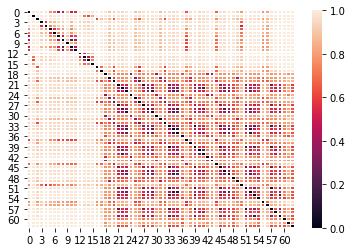

In [54]:
import seaborn as sns
ax = sns.heatmap(matrix, linewidth=0.5)#, xticklabels=cols[:-7], yticklabels=cols[:-7])
#ax.set_xticks(np.arange(len(cols[:-7])))
#ax.set_yticks(np.arange(len(cols[:-7])))
#ax.set_xticklabels(cols[:-7])
#ax.set_yticklabels(cols[:-7])
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.show()

In [56]:
# let's find the most uniform user and the most non-uniform user:
result = {}
for u in usernames:
    if not 'glove_merged' in users[u]:
        print('skipping user' + u)
        continue
    result[u] = 0.0
    for c1 in cols[:-7]:
        idx_1 = cols.get_loc(c1)
        for c2 in cols[:-7]:
            idx_2 = cols.get_loc(c2)
            stats = users[u][f'{c1}-{c2}'][0]
            result[u] += stats[0]
ordered_keys = sorted(result, key=result.get)

skipping userAE30


CB23


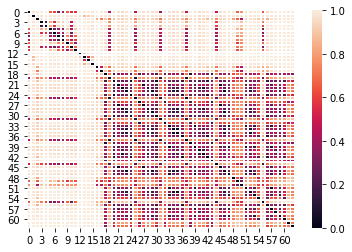

In [60]:
u = ordered_keys[0]
print(u)
matrix_u = np.zeros((len(cols[:-7]), len(cols[:-7])))
for c1 in cols[:-7]:
    idx_1 = cols.get_loc(c1)
    for c2 in cols[:-7]:
        idx_2 = cols.get_loc(c2)
        stats = users[u][f'{c1}-{c2}'][0]
        matrix_u[idx_1, idx_2] += stats[0]
ax = sns.heatmap(matrix_u, linewidth=0.5)
plt.show()

MS55


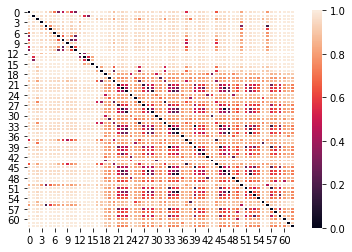

In [61]:
u = ordered_keys[-1]
print(u)
matrix_u = np.zeros((len(cols[:-7]), len(cols[:-7])))
for c1 in cols[:-7]:
    idx_1 = cols.get_loc(c1)
    for c2 in cols[:-7]:
        idx_2 = cols.get_loc(c2)
        stats = users[u][f'{c1}-{c2}'][0]
        matrix_u[idx_1, idx_2] += stats[0]
ax = sns.heatmap(matrix_u, linewidth=0.5)
plt.show()

In [69]:
def val_(username: str, columes, label_type: str, gesture: str):
    return sutils.values_for_user_for_label_type_and_gesture(
        username, users, columes, label_type, gesture, True, 
        higher_percentile, lower_percentile)

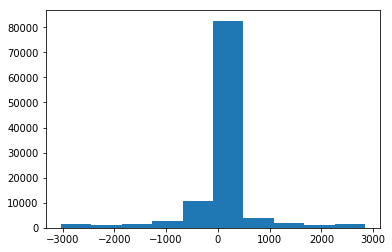

In [71]:
# according to that values of channel 21 and 22 are very similar 
# (I guess they are x,y form acceleromter) but f.e. 10. 10 again is similar to 11.
# let's check that for user MS55:
vals = val_('MS55', cols[21], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

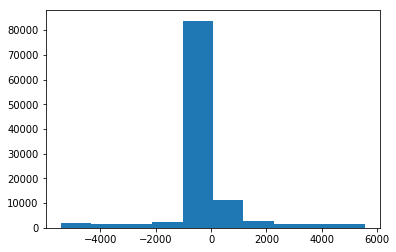

In [72]:
vals = val_('MS55', cols[22], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

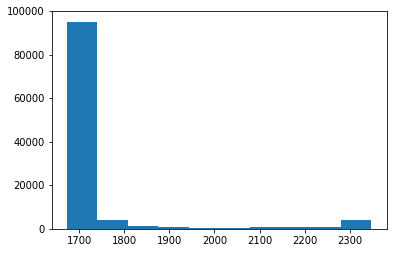

In [73]:
vals = val_('MS55', cols[10], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

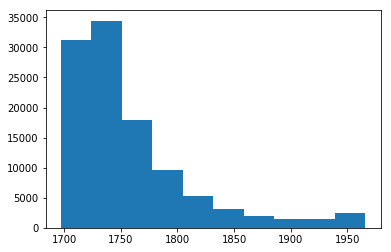

In [74]:
vals = val_('MS55', cols[11], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

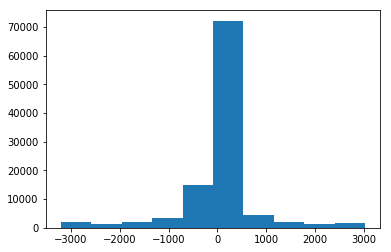

In [75]:
vals = val_('CB23', cols[21], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

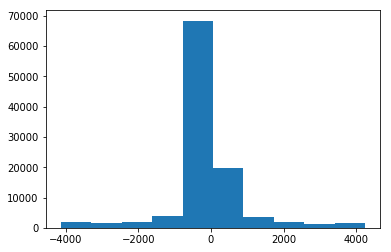

In [76]:
vals = val_('CB23', cols[22], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

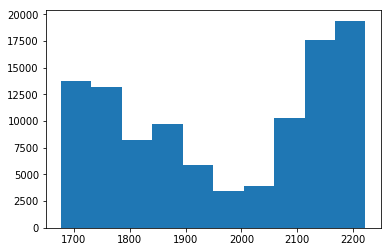

In [77]:
vals = val_('CB23', cols[10], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

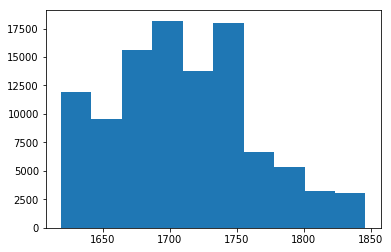

In [78]:
vals = val_('CB23', cols[11], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()